In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [58]:
# This function parse the ouput of PerkinElmer 
# Scan Array CSV File to find the start and end 
# of the output table
# It also find the cyanine 5 channel (CH1, CH2 or CH3)
# that contains
# the SH2 domain reading 
def parse_text(start_line='BEGIN DATA', 
               out_file_path=''):
    a=0
    start = 0
    end = 0
    for l in open(out_file_path):
        a+=1
        if l.startswith(start_line):
            start += a
        if l.startswith('END DATA'):
            end += a
        if 'Cyanine 5' in l:
            ch = l.split(',')[1]
            ch = ch.replace('H','h')
    return start, end, ch

In [59]:
out_file_path = os.path.join('data_file_post','714-27_FRK.csv')
start, end , ch = parse_text(out_file_path=out_file_path)
print(start, end , ch)

70 19272 Ch1


In [60]:
#now we can read an output file
df = pd.read_table(out_file_path, sep=',',
                   skiprows=start, engine ='python', 
                   skipfooter=1)
df.head()

,Index,Array Row,Array Column,Spot Row,Spot Column,Name,ID,X,Y,Diameter,...,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,1,1,1,1,1,GNEPDKYPCNGQV,>Part3-5146,3435,5436,200,...,21.26,181,185,21.31,23.0,5.2,0,3,5,8.63
1,2,1,1,1,2,NLSQGGYEELERV,>Part3-5151,3681,5436,200,...,291.77,196,195,18.25,66.0,44.9,0,32,186,12.50
2,3,1,1,1,3,ALAAEGYYDIRRV,>Part3-5166,3881,5429,200,...,21.60,199,199,28.87,17.3,1.1,0,5,6,7.07
3,4,1,1,1,4,QHDEPCYWRLTRV,>Part3-5187,4103,5429,200,...,23.90,189,189,19.18,56.9,31.1,0,26,25,11.21
4,5,1,1,1,5,EAGKPIYSRYGSV,>Part3-5199,4336,5444,200,...,19.97,186,187,17.73,25.6,8.1,0,3,4,10.66


In [61]:
df.columns

Index(['Index', 'Array Row', 'Array Column', 'Spot Row', 'Spot Column', 'Name',
       'ID', 'X', 'Y', 'Diameter', 'F Pixels', 'B Pixels', 'Footprint',
       'Flags', 'Ch1 Median', 'Ch1 Mean', 'Ch1 SD', 'Ch1 B Median',
       'Ch1 B Mean', 'Ch1 B SD', 'Ch1 % > B + 1 SD', 'Ch1 % > B + 2 SD',
       'Ch1 F % Sat.', 'Ch1 Median - B', 'Ch1 Mean - B',
       'Ch1 SignalNoiseRatio'],
      dtype='object')

# The array is composed of 3 identical blocks 
of 6400 spots, So that each spot on the array is repeated 3 times. A spot can contain a peptide or a control (dye, Marker, GST...) A peptide can be spotted multiple times on the block (count > than 3). For example RVKEEGYELPYNP and GEEEHVYSFPNKQ are spotted 3 times in different position of the block.

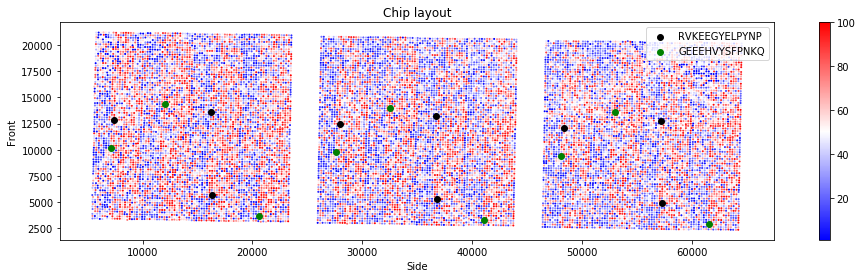

In [82]:
#create centile of signal - background
fig,ax=plt.subplots( figsize=(16,4),)
c= pd.qcut(df['Ch1 Mean - B'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter',s=1,
       c=c, colormap='bwr',ax=ax)

df[df['Name']=='RVKEEGYELPYNP'].plot(x='Y', y='X',
                                     kind='scatter', s=35, c='k',ax=ax,label='RVKEEGYELPYNP')
df[df['Name']=='GEEEHVYSFPNKQ'].plot(x='Y', y='X',
                                     kind='scatter', s=35, c='g',ax=ax,label='GEEEHVYSFPNKQ')

plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.legend()
plt.show()

# We can also visualize the background
to show experimental artefacts

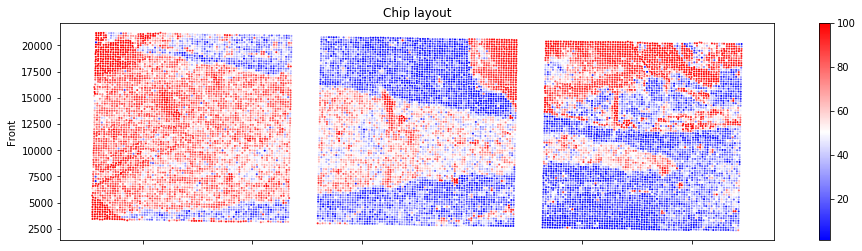

In [74]:
c= pd.qcut(df['Ch1 B Median'].rank(method='first'), 100, labels=np.arange(1,101) ).values
df.plot(x='Y', y='X',kind='scatter', figsize=(16,4), s=1,
       c=c, colormap='bwr')
plt.title('Chip layout')
plt.xlabel('Side')
plt.ylabel('Front')
plt.show()

In [83]:
# this are probably the most useful columns 
# in the output file
suffixes = [' Median',' Mean',' SD',' B Median',
         ' B Mean',' B SD',' % > B + 1 SD',' % > B + 2 SD',
         ' F % Sat.',' Median - B',' Mean - B',' SignalNoiseRatio']
# to wich we add the peptide sequence and batch identifier
cols = ['Name','ID']+[ch + n for n in suffixes]
df = df[cols]
df.head()

,Name,ID,Ch1 Median,Ch1 Mean,Ch1 SD,Ch1 B Median,Ch1 B Mean,Ch1 B SD,Ch1 % > B + 1 SD,Ch1 % > B + 2 SD,Ch1 F % Sat.,Ch1 Median - B,Ch1 Mean - B,Ch1 SignalNoiseRatio
0,GNEPDKYPCNGQV,>Part3-5146,184,186,21.26,181,185,21.31,23.0,5.2,0,3,5,8.63
1,NLSQGGYEELERV,>Part3-5151,228,382,291.77,196,195,18.25,66.0,44.9,0,32,186,12.50
2,ALAAEGYYDIRRV,>Part3-5166,204,205,21.60,199,199,28.87,17.3,1.1,0,5,6,7.07
3,QHDEPCYWRLTRV,>Part3-5187,215,214,23.90,189,189,19.18,56.9,31.1,0,26,25,11.21
4,EAGKPIYSRYGSV,>Part3-5199,189,190,19.97,186,187,17.73,25.6,8.1,0,3,4,10.66


In [85]:
#some spots contains markers
df['Name'].value_counts().head(10)

<<Marker>>       384
pY                72
TAMRA             12
Triple Flaq       12
FITC              12
GST               12
IgG               12
IgM               12
PKEDPIYDEPEGL      9
GEEEHVYSFPNKQ      9
Name: Name, dtype: int64

In [28]:
# the peptides in the array where sintetised in
# different batches
df['batch']=[n.split('-')[0] for n in df['ID']]
df.groupby('batch').size()

batch
5198_1       72
5804_1       12
5804_2       12
>Jerini     753
>Part1      492
>Part2      804
>Part3     9273
SH2          12
none       7770
dtype: int64

In [32]:
# The processing of the data is arbitray. I can suggest:
# Median of the peptide replica replicated blocks
df.groupby('Name')['Ch1 Median - B'].median().sort_values().tail(20)

Name
DNDITPYLVSRFY    23311.0
FWGCDSYANLNTE    23725.0
HTGEKPYACLECG    23794.0
DYEIDQYEEFCFS    23848.0
PYSQKRYEEIVKE    24015.0
KFTSKEYEEIDKR    25362.0
LEQRKEYEEIMRD    25749.0
HSGEKPYECVECG    27138.0
LCLSSIYEDLKMY    27621.0
RMNDLHYLNLDTW    27839.0
HTGEKPYECIKCG    28383.0
CTLWEAYANLHTA    29277.0
RVCEPCYEQLNRK    29893.5
EALDKVYEEIEKD    31510.0
LTAEFLYDEVHPK    32811.0
ELQANCYEEVKDR    33585.0
RWLAVDYENVRPD    36132.0
LTADFLYEEVHPK    42226.0
TFNVDMYEEIHRK    46787.0
LGTVMRYEEIELR    47020.0
Name: Ch1 Median - B, dtype: float64

In [30]:
# The files starting with different 
# nubers have a different layout of the 
# blocks: 816 and 811 have same layout that differs from 714
fnames = []
for fname in os.listdir('data_file_post'):
    if fname.endswith('csv'):
        fnames.append(fname.split('-')[0])
print(set(fnames))


{'816', '714', '811'}


In [ ]:
# chereoo 